In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import pvlib
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('df_mes.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_utc'] = df['datetime'].dt.tz_localize('UTC')
df['datetime_local'] = df['datetime_utc'].dt.tz_convert('America/Sao_Paulo')
display(df)

,Month,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine,datetime_utc,datetime_local
0,1,0,0,0,114.47,2.9,2019-01-01 00:00:00,15,228.129189,0.000000,0.000000,1.000000,2019-01-01 00:00:00+00:00,2018-12-31 22:00:00-02:00
1,1,0,0,0,119.37,2.8,2019-01-01 00:30:00,15,222.677718,0.000000,0.130526,0.991445,2019-01-01 00:30:00+00:00,2018-12-31 22:30:00-02:00
2,1,0,0,0,123.75,2.8,2019-01-01 01:00:00,15,216.419942,0.000000,0.258819,0.965926,2019-01-01 01:00:00+00:00,2018-12-31 23:00:00-02:00
3,1,0,0,0,127.48,2.7,2019-01-01 01:30:00,15,209.279223,0.000000,0.382683,0.923880,2019-01-01 01:30:00+00:00,2018-12-31 23:30:00-02:00
4,1,0,0,0,130.42,2.7,2019-01-01 02:00:00,15,201.247715,0.000000,0.500000,0.866025,2019-01-01 02:00:00+00:00,2019-01-01 00:00:00-02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12,32,151,45,85.18,2.8,2019-12-31 21:30:00,55,246.845935,9.925587,-0.608761,0.793353,2019-12-31 21:30:00+00:00,2019-12-31 18:30:00-03:00
17516,12,0,0,0,91.58,3.0,2019-12-31 22:00:00,15,243.925505,0.000000,-0.500000,0.866025,2019-12-31 22:00:00+00:00,2019-12-31 19:00:00-03:00
17517,12,0,0,0,97.66,3.0,2019-12-31 22:30:00,15,240.669099,0.000000,-0.382683,0.923880,2019-12-31 22:30:00+00:00,2019-12-31 19:30:00-03:00
17518,12,0,0,0,103.55,3.0,2019-12-31 23:00:00,15,237.004479,0.000000,-0.258819,0.965926,2019-12-31 23:00:00+00:00,2019-12-31 20:00:00-03:00


Divisão do algoritmo nos períodos de backtracking (5:30-7:30 e 15:30-20:00)

Se o ângulo ótimo for maior que do pvlib mantem-se o do pvlib 

In [3]:
from datetime import time 

'''
# Condições para intervalos que não atravessam a meia-noite
cond_early_morning = (df['datetime_local'].dt.time >= time(5, 30)) & (df['datetime_local'].dt.time <= time(7, 30))
cond_afternoon = (df['datetime_local'].dt.time >= time(15, 30))
# Condição para intervalo que atravessa a meia-noite
cond_late_night = (df['datetime_local'].dt.time <= time(5, 30))

# Aplicação das condições
df['Angulo real'] = np.where(
    cond_early_morning | cond_afternoon | cond_late_night,
    np.where(abs(df['Angulo']) > abs(df['tracker_theta']), df['tracker_theta'], df['Angulo']),
    df['Angulo']
)

display(df)

'''
#np.where(condição, valor_se_verdadeiro, valor_se_falso)
df['Angulo real'] = np.where(
    ((df['datetime_local'].dt.time >= time(5,30)) & (df['datetime_local'].dt.time <= time(7,30))) |
    ((df['datetime_local'].dt.time >= time(15,30)) & (df['datetime_local'].dt.time <= time(18,00))),
    np.where(abs(df['Angulo']) > abs(df['tracker_theta']), df['tracker_theta'], df['Angulo']),
    df['Angulo']
)

display(df)


,Month,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine,datetime_utc,datetime_local,Angulo real
0,1,0,0,0,114.47,2.9,2019-01-01 00:00:00,15,228.129189,0.000000,0.000000,1.000000,2019-01-01 00:00:00+00:00,2018-12-31 22:00:00-02:00,15.0
1,1,0,0,0,119.37,2.8,2019-01-01 00:30:00,15,222.677718,0.000000,0.130526,0.991445,2019-01-01 00:30:00+00:00,2018-12-31 22:30:00-02:00,15.0
2,1,0,0,0,123.75,2.8,2019-01-01 01:00:00,15,216.419942,0.000000,0.258819,0.965926,2019-01-01 01:00:00+00:00,2018-12-31 23:00:00-02:00,15.0
3,1,0,0,0,127.48,2.7,2019-01-01 01:30:00,15,209.279223,0.000000,0.382683,0.923880,2019-01-01 01:30:00+00:00,2018-12-31 23:30:00-02:00,15.0
4,1,0,0,0,130.42,2.7,2019-01-01 02:00:00,15,201.247715,0.000000,0.500000,0.866025,2019-01-01 02:00:00+00:00,2019-01-01 00:00:00-02:00,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12,32,151,45,85.18,2.8,2019-12-31 21:30:00,55,246.845935,9.925587,-0.608761,0.793353,2019-12-31 21:30:00+00:00,2019-12-31 18:30:00-03:00,55.0
17516,12,0,0,0,91.58,3.0,2019-12-31 22:00:00,15,243.925505,0.000000,-0.500000,0.866025,2019-12-31 22:00:00+00:00,2019-12-31 19:00:00-03:00,15.0
17517,12,0,0,0,97.66,3.0,2019-12-31 22:30:00,15,240.669099,0.000000,-0.382683,0.923880,2019-12-31 22:30:00+00:00,2019-12-31 19:30:00-03:00,15.0
17518,12,0,0,0,103.55,3.0,2019-12-31 23:00:00,15,237.004479,0.000000,-0.258819,0.965926,2019-12-31 23:00:00+00:00,2019-12-31 20:00:00-03:00,15.0


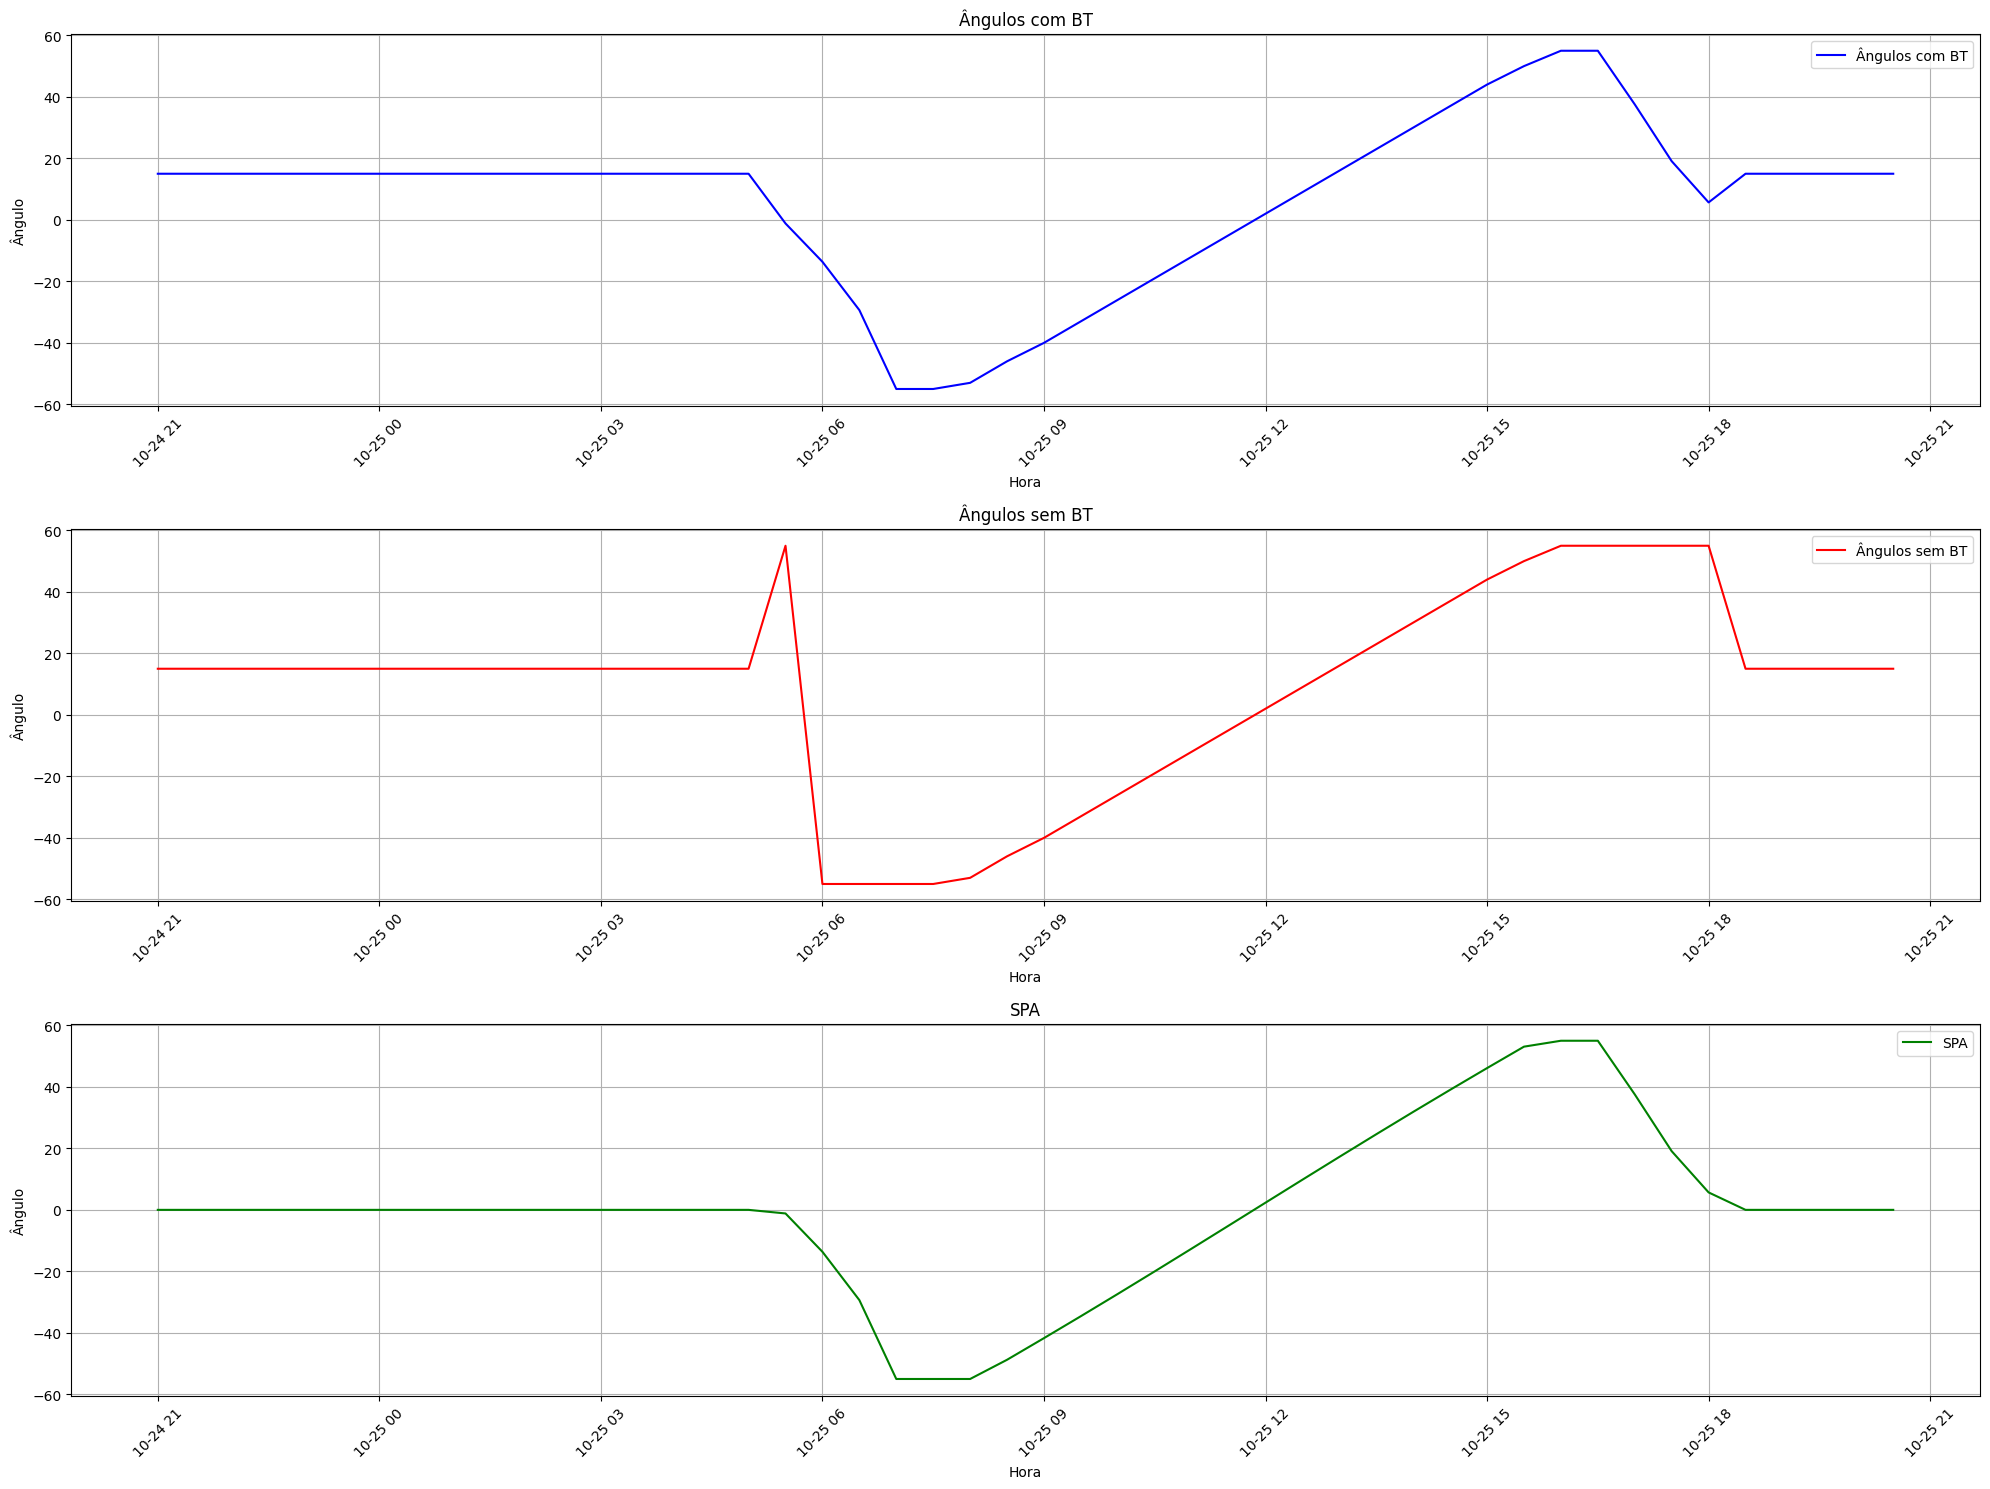

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Selecione o intervalo de datetime correspondente aos índices desejados [14016:14064]  
datetime_selecionados = df['datetime_local'][14256:14304]    
angulosBT_selecionados = df['Angulo real'][14256:14304]           
angulos_selecionados = df['Angulo'][14256:14304]          
angulos = df['tracker_theta'][14256:14304]          

# Criar a figura e os subplots (3 linhas, 1 coluna)
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

# Gráfico 1: Ângulos com BT
axs[0].plot(datetime_selecionados, angulosBT_selecionados, label='Ângulos com BT', color='blue')
axs[0].set_title('Ângulos com BT')
axs[0].set_xlabel('Hora')
axs[0].set_ylabel('Ângulo')
axs[0].legend()
axs[0].grid(True)
axs[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Ângulos sem BT
axs[1].plot(datetime_selecionados, angulos_selecionados, label='Ângulos sem BT', color='red')
axs[1].set_title('Ângulos sem BT')
axs[1].set_xlabel('Hora')
axs[1].set_ylabel('Ângulo')
axs[1].legend()
axs[1].grid(True)
axs[1].tick_params(axis='x', rotation=45)

# Gráfico 3: SPA
axs[2].plot(datetime_selecionados, angulos, label='SPA', color='green')
axs[2].set_title('SPA')
axs[2].set_xlabel('Hora')
axs[2].set_ylabel('Ângulo')
axs[2].legend()
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=45)

# Ajustar layout para que os plots não se sobreponham
plt.tight_layout()

# Mostrar a figura com os três subplots
plt.show()


In [5]:
from sklearn.preprocessing import MinMaxScaler
# Mantem datetime e theta na divisão 
X = df[['Month','Wind Speed','Solar Zenith Angle','GHI','azimuth','Hour Sine','Hour Cosine','datetime','datetime_local','tracker_theta','DNI','DHI']]
#display(X)
y = df[['Angulo real']] 
#display(y)

# Shuffle preserva a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=42)
display(X_train)
display(X_test)
datetime = X_test['datetime']
datetime_local = X_test['datetime_local']
display(datetime)
tracker_theta = X_test['tracker_theta']
display(tracker_theta)
dni = X_test['DNI']
dhi = X_test['DHI']
ghi = X_test['GHI']
print(X_train.columns)
print(X_test.columns)
cols = ['datetime','datetime_local', 'tracker_theta','DNI','DHI']
X_train = X_train.drop(columns=cols, axis=1)
display(X_train)
X_test = X_test.drop(columns=cols, axis=1)
display(X_test)


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,datetime_local,tracker_theta,DNI,DHI
0,1,2.9,114.47,0,228.129189,0.000000,1.000000,2019-01-01 00:00:00,2018-12-31 22:00:00-02:00,0.0,0,0
1,1,2.8,119.37,0,222.677718,0.130526,0.991445,2019-01-01 00:30:00,2018-12-31 22:30:00-02:00,0.0,0,0
2,1,2.8,123.75,0,216.419942,0.258819,0.965926,2019-01-01 01:00:00,2018-12-31 23:00:00-02:00,0.0,0,0
3,1,2.7,127.48,0,209.279223,0.382683,0.923880,2019-01-01 01:30:00,2018-12-31 23:30:00-02:00,0.0,0,0
4,1,2.7,130.42,0,201.247715,0.500000,0.866025,2019-01-01 02:00:00,2019-01-01 00:00:00-02:00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14011,10,4.9,94.64,0,256.847983,-0.608761,0.793353,2019-10-19 21:30:00,2019-10-19 18:30:00-03:00,0.0,0,0
14012,10,4.7,101.29,0,253.594838,-0.500000,0.866025,2019-10-19 22:00:00,2019-10-19 19:00:00-03:00,0.0,0,0
14013,10,4.6,107.82,0,250.029589,-0.382683,0.923880,2019-10-19 22:30:00,2019-10-19 19:30:00-03:00,0.0,0,0
14014,10,4.5,114.19,0,246.033318,-0.258819,0.965926,2019-10-19 23:00:00,2019-10-19 20:00:00-03:00,0.0,0,0


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,datetime_local,tracker_theta,DNI,DHI
14016,10,4.3,126.23,0,236.104717,0.000000,1.000000,2019-10-20 00:00:00,2019-10-19 21:00:00-03:00,0.000000,0,0
14017,10,4.3,131.71,0,229.738716,0.130526,0.991445,2019-10-20 00:30:00,2019-10-19 21:30:00-03:00,0.000000,0,0
14018,10,4.2,136.65,0,222.074019,0.258819,0.965926,2019-10-20 01:00:00,2019-10-19 22:00:00-03:00,0.000000,0,0
14019,10,4.2,140.84,0,212.833073,0.382683,0.923880,2019-10-20 01:30:00,2019-10-19 22:30:00-03:00,0.000000,0,0
14020,10,4.1,144.00,0,201.875372,0.500000,0.866025,2019-10-20 02:00:00,2019-10-19 23:00:00-03:00,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12,2.8,85.18,45,246.845935,-0.608761,0.793353,2019-12-31 21:30:00,2019-12-31 18:30:00-03:00,9.925587,151,32
17516,12,3.0,91.58,0,243.925505,-0.500000,0.866025,2019-12-31 22:00:00,2019-12-31 19:00:00-03:00,0.000000,0,0
17517,12,3.0,97.66,0,240.669099,-0.382683,0.923880,2019-12-31 22:30:00,2019-12-31 19:30:00-03:00,0.000000,0,0
17518,12,3.0,103.55,0,237.004479,-0.258819,0.965926,2019-12-31 23:00:00,2019-12-31 20:00:00-03:00,0.000000,0,0


14016   2019-10-20 00:00:00
14017   2019-10-20 00:30:00
14018   2019-10-20 01:00:00
14019   2019-10-20 01:30:00
14020   2019-10-20 02:00:00
                ...        
17515   2019-12-31 21:30:00
17516   2019-12-31 22:00:00
17517   2019-12-31 22:30:00
17518   2019-12-31 23:00:00
17519   2019-12-31 23:30:00
Name: datetime, Length: 3504, dtype: datetime64[ns]

14016    0.000000
14017    0.000000
14018    0.000000
14019    0.000000
14020    0.000000
           ...   
17515    9.925587
17516    0.000000
17517    0.000000
17518    0.000000
17519    0.000000
Name: tracker_theta, Length: 3504, dtype: float64

Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'datetime_local',
       'tracker_theta', 'DNI', 'DHI'],
      dtype='object')
Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'datetime_local',
       'tracker_theta', 'DNI', 'DHI'],
      dtype='object')


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
0,1,2.9,114.47,0,228.129189,0.000000,1.000000
1,1,2.8,119.37,0,222.677718,0.130526,0.991445
2,1,2.8,123.75,0,216.419942,0.258819,0.965926
3,1,2.7,127.48,0,209.279223,0.382683,0.923880
4,1,2.7,130.42,0,201.247715,0.500000,0.866025
...,...,...,...,...,...,...,...
14011,10,4.9,94.64,0,256.847983,-0.608761,0.793353
14012,10,4.7,101.29,0,253.594838,-0.500000,0.866025
14013,10,4.6,107.82,0,250.029589,-0.382683,0.923880
14014,10,4.5,114.19,0,246.033318,-0.258819,0.965926


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
14016,10,4.3,126.23,0,236.104717,0.000000,1.000000
14017,10,4.3,131.71,0,229.738716,0.130526,0.991445
14018,10,4.2,136.65,0,222.074019,0.258819,0.965926
14019,10,4.2,140.84,0,212.833073,0.382683,0.923880
14020,10,4.1,144.00,0,201.875372,0.500000,0.866025
...,...,...,...,...,...,...,...
17515,12,2.8,85.18,45,246.845935,-0.608761,0.793353
17516,12,3.0,91.58,0,243.925505,-0.500000,0.866025
17517,12,3.0,97.66,0,240.669099,-0.382683,0.923880
17518,12,3.0,103.55,0,237.004479,-0.258819,0.965926


In [6]:
# Tratamento
scaler = MinMaxScaler()
colunas = ['GHI', 'Wind Speed', 'Solar Zenith Angle','azimuth','Month']

X_train[colunas] = scaler.fit_transform(X_train[colunas])
X_test[colunas] = scaler.transform(X_test[colunas])

scaler_y = MinMaxScaler()
#y_train['Angulo real'] = scaler_y.fit_transform(y_train[['Angulo real']])
#y_test['Angulo real'] = scaler_y.transform(y_test[['Angulo real']])
y_train = scaler_y.fit_transform(y_train[['Angulo real']]).ravel()  # Ajusta o formato
y_test = scaler_y.transform(y_test[['Angulo real']]).ravel()  # Ajusta o formato

#display(X_train)
#display(X_test)
#display(y_train)
#display(y_test)

Comparação entre os modelos Random Forest e MLP

In [7]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

mlp_model = MLPRegressor()    
mlp_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
import numpy as np
y_pred = rf_model.predict(X_test)
# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))
mae = mean_absolute_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
rmse = np.sqrt(mean_squared_error(y_true=y_test_desnormalizado, y_pred=y_pred_desnormalizado))
r2 = r2_score(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
print("Métricas com Random Forest")
print("Erro médio absoluto", mae)
print("Raíz do erro médio quadrático", rmse)
print ("R2", r2)

y_pred1 = mlp_model.predict(X_test)
y_pred_desnormalizado1 = scaler_y.inverse_transform(y_pred1.reshape(-1, 1))
y_test_desnormalizado1 = scaler_y.inverse_transform(y_test.reshape(-1, 1))
mae1 = mean_absolute_error(y_pred=y_pred_desnormalizado1, y_true=y_test_desnormalizado1)
mse1 = mean_squared_error(y_pred=y_pred_desnormalizado1, y_true=y_test_desnormalizado1)
rmse1 = np.sqrt(mean_squared_error(y_true=y_test_desnormalizado1, y_pred=y_pred_desnormalizado1))
r21 = r2_score(y_pred=y_pred_desnormalizado1, y_true=y_test_desnormalizado1)
print("\nMétricas com MLP")
print("Erro médio absoluto", mae1)
print("Raíz do erro médio quadrático", rmse1)
print ("R2", r21)

Métricas com Random Forest
Erro médio absoluto 1.8693834241939429
Raíz do erro médio quadrático 4.68461735595307
R2 0.9470525197955572

Métricas com MLP
Erro médio absoluto 4.809128395599991
Raíz do erro médio quadrático 7.722978196562426
R2 0.856098053669422


In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Previsões do modelo
y_pred = rf_model.predict(X_test)

# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Filtrar apenas os ângulos que não são 15 graus (considerando que isso indica noite)
mask_diurno = y_test_desnormalizado != 15  # Comparação direta no array
y_pred_diurno = y_pred_desnormalizado[mask_diurno]
y_test_diurno_desnormalizado = y_test_desnormalizado[mask_diurno]

# Calcular as métricas apenas para o período diurno
mae = mean_absolute_error(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)
rmse = np.sqrt(mse)
r2 = r2_score(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)

print("Erro médio absoluto:", mae)
print("Raíz do erro médio quadrático:", rmse)
print("R2:", r2)


Erro médio absoluto: 2.464602954226242
Raíz do erro médio quadrático: 5.137337776957462
R2: 0.958329018659678


Gridsearch Random Forest

In [16]:
# COLOCAR Y DESNORMALZADO NO GRIDSEARCH
from sklearn.model_selection import GridSearchCV, KFold

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100,200,300,500],  
    'max_features':[None,'sqrt','log2'], 
    'max_depth': [None, 5, 10, 20],  
    'max_leaf_nodes':[None,2, 6, 10],
    'min_samples_split': [2, 4, 6],  
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha':[0, 0.1, 0.01]   
    #'min_impurity_decrease': [0.0, 0.01, 0.1], 
    #'min_weight_fraction_leaf': [0.0, 0.01]      
}


kfold = KFold(n_splits=3, shuffle=False)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_absolute_error', 
                           cv=kfold, n_jobs=None, verbose=1)


grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
sorted_results = results.sort_values(by='mean_test_score', ascending=False)
display(sorted_results)



Fitting 3 folds for each of 5184 candidates, totalling 15552 fits
Melhores parâmetros: {'ccp_alpha': 0, 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1298,12.761507,1.554025,0.177808,0.015815,0.0,20.0,None,NaN,1,2,300,"{'ccp_alpha': 0, 'max_depth': 20, 'max_feature...",-0.024412,-0.008368,-0.007947,-0.013576,0.007664,1
2,9.700402,1.182101,0.122234,0.013580,0.0,NaN,None,NaN,1,2,300,"{'ccp_alpha': 0, 'max_depth': None, 'max_featu...",-0.024424,-0.008366,-0.007945,-0.013578,0.007671,2
1,6.551326,0.734510,0.086383,0.003126,0.0,NaN,None,NaN,1,2,200,"{'ccp_alpha': 0, 'max_depth': None, 'max_featu...",-0.024514,-0.008305,-0.007951,-0.013590,0.007726,3
1297,8.516778,1.067361,0.111181,0.007791,0.0,20.0,None,NaN,1,2,200,"{'ccp_alpha': 0, 'max_depth': 20, 'max_feature...",-0.024502,-0.008304,-0.007968,-0.013591,0.007716,4
3,16.145962,1.883545,0.210713,0.020376,0.0,NaN,None,NaN,1,2,500,"{'ccp_alpha': 0, 'max_depth': None, 'max_featu...",-0.024514,-0.008364,-0.007983,-0.013620,0.007705,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,3.409568,0.066908,0.022487,0.009050,0.1,20.0,None,6.0,4,4,200,"{'ccp_alpha': 0.1, 'max_depth': 20, 'max_featu...",-0.144422,-0.144876,-0.144899,-0.144732,0.000219,4753
2277,3.106386,0.170647,0.026618,0.015027,0.1,5.0,None,10.0,1,6,200,"{'ccp_alpha': 0.1, 'max_depth': 5, 'max_featur...",-0.144422,-0.144876,-0.144899,-0.144732,0.000219,4753
3121,3.480728,0.192222,0.019398,0.003570,0.1,20.0,None,6.0,4,2,200,"{'ccp_alpha': 0.1, 'max_depth': 20, 'max_featu...",-0.144422,-0.144876,-0.144899,-0.144732,0.000219,4753
3117,3.388135,0.101152,0.017487,0.001141,0.1,20.0,None,6.0,2,6,200,"{'ccp_alpha': 0.1, 'max_depth': 20, 'max_featu...",-0.144422,-0.144876,-0.144899,-0.144732,0.000219,4753


In [17]:
sorted_results.to_csv('gridsearch.csv')

In [18]:
# Rodando random forest novamente agora com os melhores parametros
best_params = grid_search.best_params_

rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    max_leaf_nodes=best_params['max_leaf_nodes'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    ccp_alpha=best_params['ccp_alpha'],
    random_state=42  
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(ccp_alpha=0, max_depth=20, max_features=None,
                      n_estimators=300, random_state=42)

In [19]:
import numpy as np
y_pred = rf_model.predict(X_test)
# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))
mae = mean_absolute_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
rmse = np.sqrt(mean_squared_error(y_true=y_test_desnormalizado, y_pred=y_pred_desnormalizado))
r2 = r2_score(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
print("Erro médio absoluto", mae)
print("Raíz do erro médio quadrático", rmse)
print ("R2", r2)

Erro médio absoluto 1.853296876253056
Raíz do erro médio quadrático 4.648236082630612
R2 0.947871718753763


In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Previsões do modelo
y_pred = rf_model.predict(X_test)

# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Filtrar apenas os ângulos que não são 15 graus (considerando que isso indica noite)
mask_diurno = y_test_desnormalizado != 15  # Comparação direta no array
y_pred_diurno = y_pred_desnormalizado[mask_diurno]
y_test_diurno_desnormalizado = y_test_desnormalizado[mask_diurno]

# Calcular as métricas apenas para o período diurno
mae = mean_absolute_error(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)
rmse = np.sqrt(mse)
r2 = r2_score(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)

print("Erro médio absoluto:", mae)
print("Raíz do erro médio quadrático:", rmse)
print("R2:", r2)


Erro médio absoluto: 2.4344972251613752
Raíz do erro médio quadrático: 5.077325713064378
R2: 0.9592968955320367


In [10]:
# .ravel transforma as colunas em unidimensionais novamente
resultados = pd.DataFrame({
    'Real': y_test_desnormalizado.ravel(),
    'Predito': y_pred_desnormalizado.ravel(),
    'Datetime':datetime,
    'Datetime_local':datetime_local,
    'Theta': tracker_theta,
    'GHI': ghi,
    'DNI': dni,
    'DHI': dhi
})
display(resultados)

,Real,Predito,Datetime,Datetime_local,Theta,GHI,DNI,DHI
14016,15.0,15.00,2019-10-20 00:00:00,2019-10-19 21:00:00-03:00,0.000000,0,0,0
14017,15.0,15.00,2019-10-20 00:30:00,2019-10-19 21:30:00-03:00,0.000000,0,0,0
14018,15.0,15.00,2019-10-20 01:00:00,2019-10-19 22:00:00-03:00,0.000000,0,0,0
14019,15.0,15.00,2019-10-20 01:30:00,2019-10-19 22:30:00-03:00,0.000000,0,0,0
14020,15.0,15.00,2019-10-20 02:00:00,2019-10-19 23:00:00-03:00,0.000000,0,0,0
...,...,...,...,...,...,...,...,...
17515,55.0,52.87,2019-12-31 21:30:00,2019-12-31 18:30:00-03:00,9.925587,45,151,32
17516,15.0,15.00,2019-12-31 22:00:00,2019-12-31 19:00:00-03:00,0.000000,0,0,0
17517,15.0,15.00,2019-12-31 22:30:00,2019-12-31 19:30:00-03:00,0.000000,0,0,0
17518,15.0,15.00,2019-12-31 23:00:00,2019-12-31 20:00:00-03:00,0.000000,0,0,0


In [11]:
resultados.to_csv("resultados.csv")

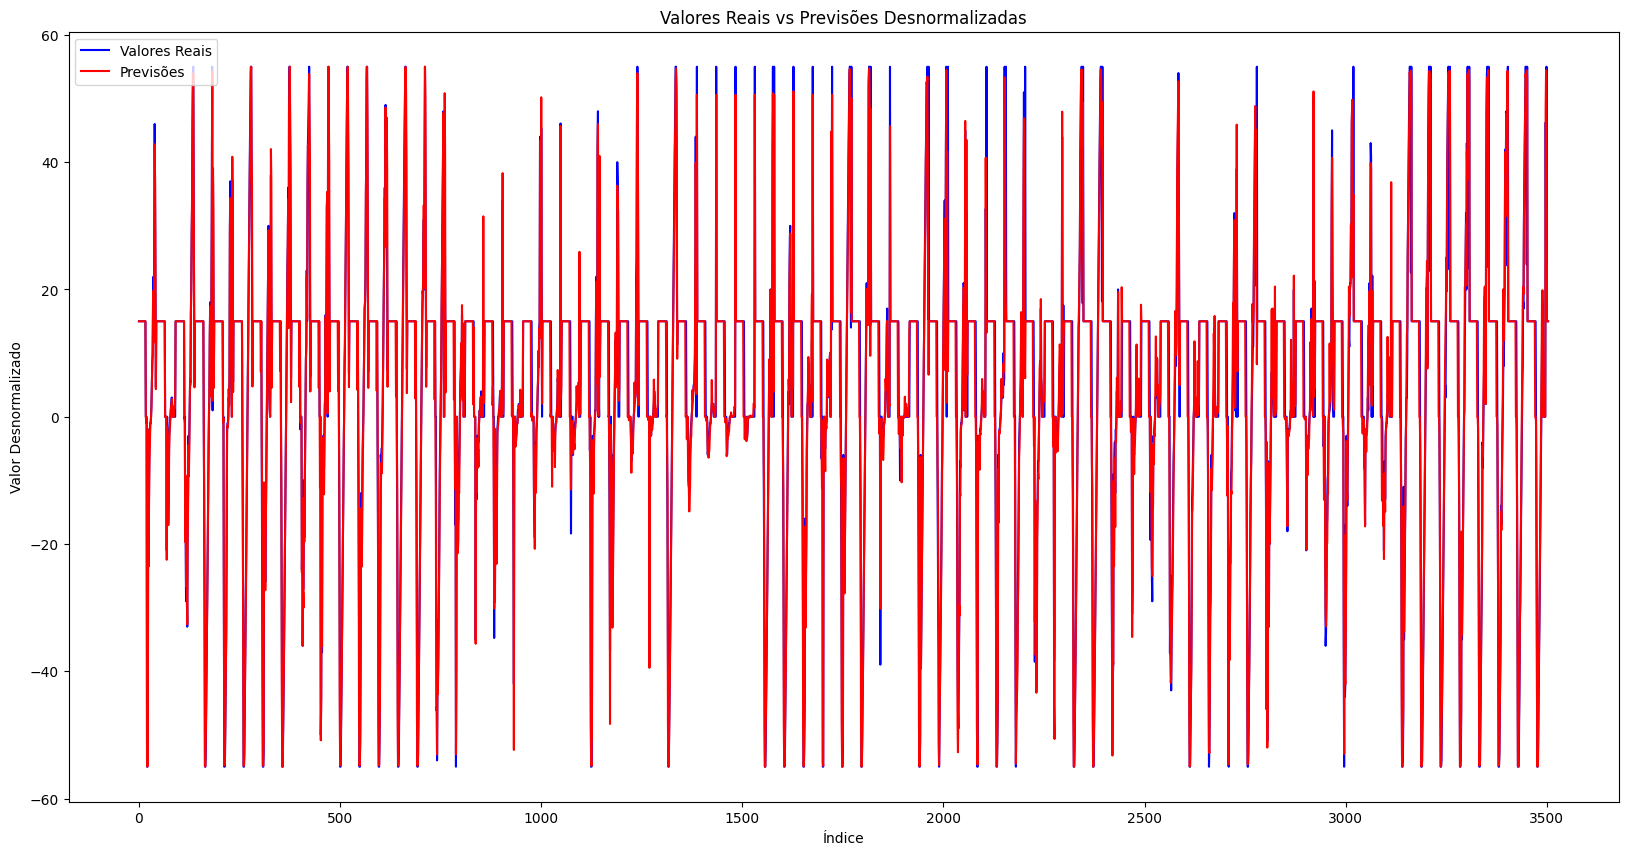

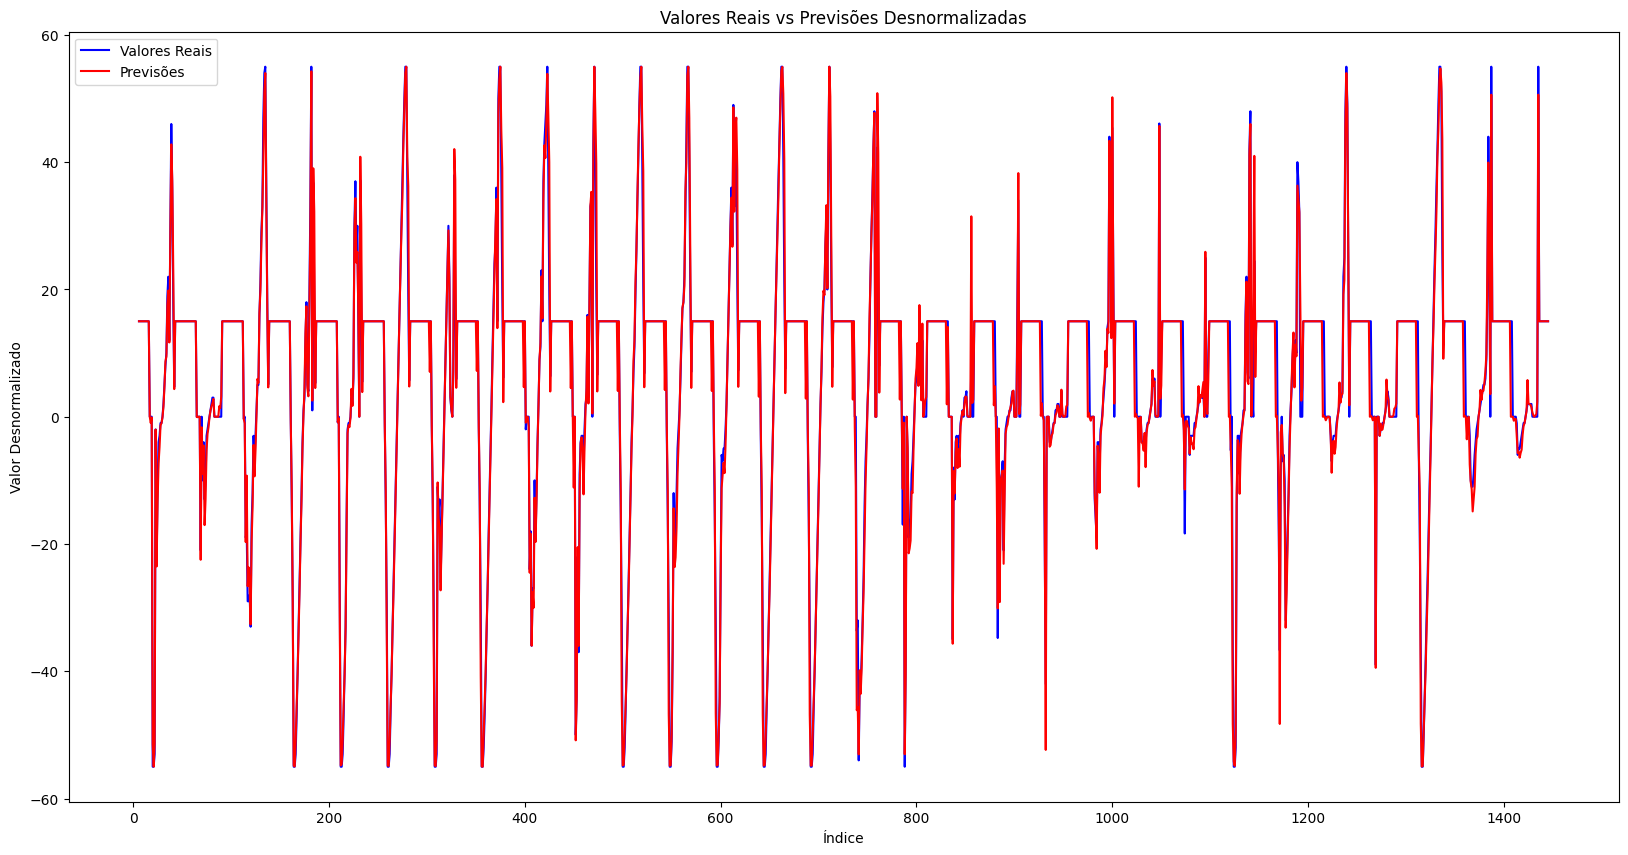

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(y_test_desnormalizado, label='Valores Reais', color='blue')
plt.plot(y_pred_desnormalizado, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()
plt.show()

indices_desejados = range(6,1446)  # 1441 é exclusivo, então inclui até 1440
y_test_selecionado = y_test_desnormalizado[6:1446]  
y_pred_selecionado = y_pred_desnormalizado[6:1446]

plt.figure(figsize=(20, 10))
plt.plot(indices_desejados, y_test_selecionado, label='Valores Reais', color='blue')
plt.plot(indices_desejados, y_pred_selecionado, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()
plt.show()


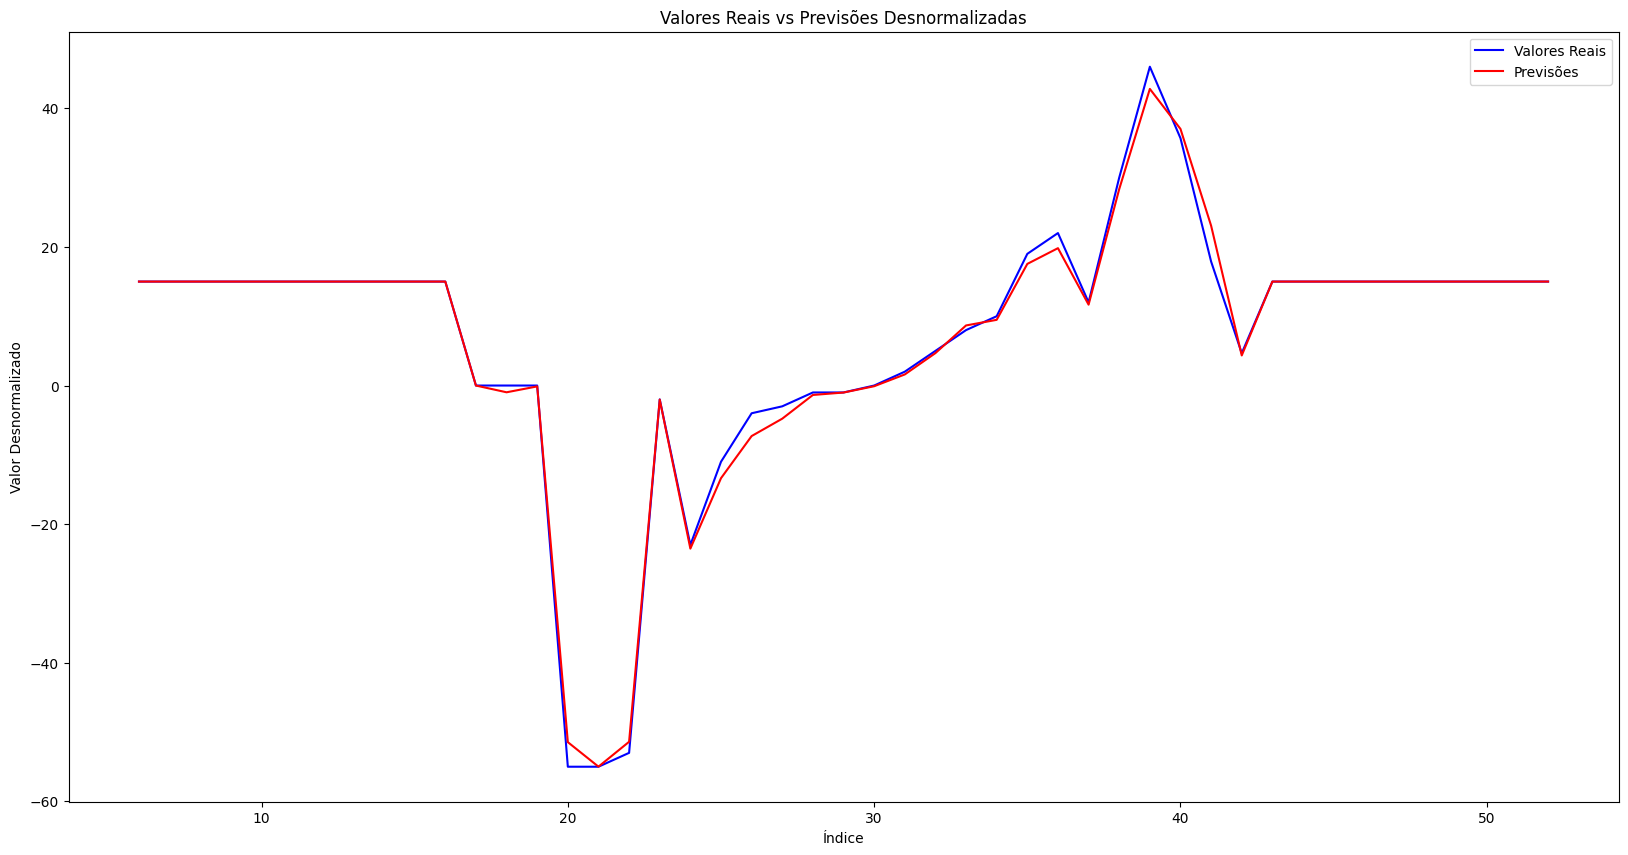

In [13]:
# 30/10 Ensolarado
indices_desejados = range(6,53)  
y_test_selecionado = y_test_desnormalizado[6:53]  
y_pred_selecionado = y_pred_desnormalizado[6:53]  

plt.figure(figsize=(20, 10))
plt.plot(indices_desejados, y_test_selecionado, label='Valores Reais', color='blue')
plt.plot(indices_desejados, y_pred_selecionado, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()
plt.show()